In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 46.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompat

In [7]:
import gensim.downloader as api
wv_pretrained = api.load('word2vec-google-news-300')

In [8]:
words = ['computer', 'city', 'music', 'teacher', 'happy']
for word in words:
    print(f"Most similar to '{word}':")
    print(wv_pretrained.most_similar(word, topn=5))

Most similar to 'computer':
[('computers', 0.7979380488395691), ('laptop', 0.6640493869781494), ('laptop_computer', 0.6548868417739868), ('Computer', 0.6473335027694702), ('com_puter', 0.6082080006599426)]
Most similar to 'city':
[('citys', 0.6803998947143555), ('mayor', 0.6751152873039246), ('town', 0.6723740100860596), ('municipality', 0.6530812978744507), ('municipal', 0.6222546100616455)]
Most similar to 'music':
[('classical_music', 0.7197793126106262), ('jazz', 0.683463990688324), ('Music', 0.6595720648765564), ('Without_Donny_Kirshner', 0.6416222453117371), ('songs', 0.6396344304084778)]
Most similar to 'teacher':
[('teachers', 0.7434301972389221), ('Teacher', 0.7094014286994934), ('guidance_counselor', 0.6960431933403015), ('elementary', 0.6790565848350525), ('PE_teacher', 0.6539357304573059)]
Most similar to 'happy':
[('glad', 0.7408890724182129), ('pleased', 0.6632171273231506), ('ecstatic', 0.6626912355422974), ('overjoyed', 0.6599286198616028), ('thrilled', 0.65140491724014

In [9]:
# king - man + woman ~ queen
print(wv_pretrained.most_similar(positive=['king', 'woman'], negative=['man'], topn=1))

# Example analogies
# France - Paris + Tokyo ~= Japan
print(wv_pretrained.most_similar(positive=['Japan', 'Paris'], negative=['France'], topn=1))

# walking - walk + swimming ~= swim
print(wv_pretrained.most_similar(positive=['swimming', 'walk'], negative=['walking'], topn=1))

# coding - code + write ~= writing
print(wv_pretrained.most_similar(positive=['write', 'code'], negative=['coding'], topn=1))


[('queen', 0.7118192911148071)]
[('Tokyo', 0.8142861723899841)]
[('swim', 0.8259809017181396)]
[('written', 0.4334881603717804)]


In [10]:
import pandas as pd

df = pd.read_csv('/kaggle/input/imdb-dataset/IMDB Dataset.csv')
print(df.head())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [11]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = ''.join([ch for ch in text if ch not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

df['tokens'] = df['review'].apply(clean_text)


In [12]:
def get_w2v_mean(tokens, model, size=300):
    vectors = [model[word] for word in tokens if word in model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(size)

import numpy as np

X_w2v = np.array(df['tokens'].apply(lambda x: get_w2v_mean(x, wv_pretrained)).tolist())
y = df['sentiment'].map({'negative': 0, 'positive': 1}).values


In [13]:
from gensim.models import Word2Vec

sentences = df['tokens'].tolist()

# Skip-gram
sg_model = Word2Vec(sentences, vector_size=100, sg=1, window=3, min_count=1, workers=4)
X_skipgram = np.array([np.mean([sg_model.wv[word] for word in tokens if word in sg_model.wv] or [np.zeros(100)], axis=0) for tokens in sentences])

# CBOW
cbow_model = Word2Vec(sentences, vector_size=100, sg=0, window=3, min_count=1, workers=4)
X_cbow = np.array([np.mean([cbow_model.wv[word] for word in tokens if word in cbow_model.wv] or [np.zeros(100)], axis=0) for tokens in sentences])


In [14]:
from gensim.models import FastText

fasttext_model = FastText(sentences, vector_size=100, sg=1, window=3, min_count=1, workers=4)
X_fasttext = np.array([np.mean([fasttext_model.wv[word] for word in tokens if word in fasttext_model.wv] or [np.zeros(100)], axis=0) for tokens in sentences])


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

def train_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    return accuracy_score(y_test, pred), f1_score(y_test, pred)

results = {}
results['Pre-trained W2V'] = train_and_evaluate(X_w2v, y)
results['Custom Skip-gram'] = train_and_evaluate(X_skipgram, y)
results['Custom CBOW'] = train_and_evaluate(X_cbow, y)
results['Custom FastText'] = train_and_evaluate(X_fasttext, y)


In [19]:
for model_name, (acc, f1) in results.items():
    print(f"{model_name}: Accuracy = {acc:.4f}, F1-score = {f1:.4f}")


Pre-trained W2V: Accuracy = 0.8529, F1-score = 0.8541
Custom Skip-gram: Accuracy = 0.8702, F1-score = 0.8717
Custom CBOW: Accuracy = 0.8556, F1-score = 0.8577
Custom FastText: Accuracy = 0.8687, F1-score = 0.8705


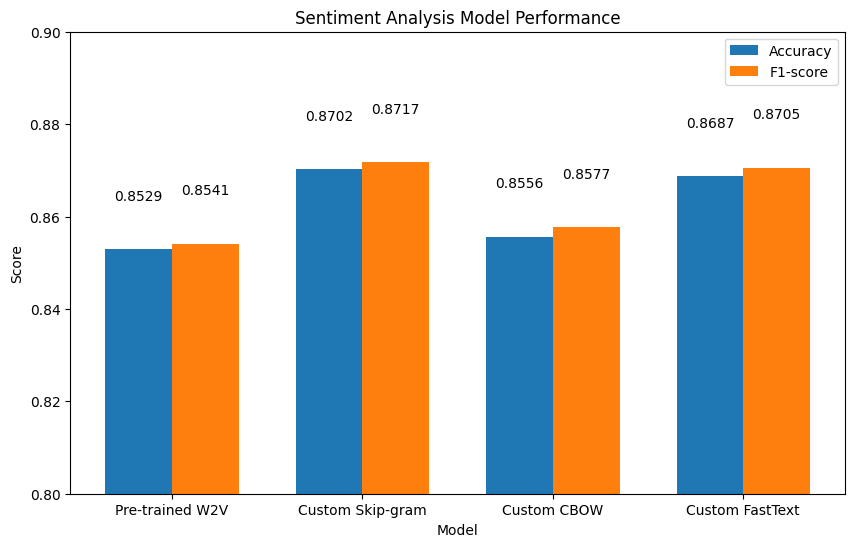

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

models = list(results.keys())
accuracy_scores = [results[m][0] for m in models]
f1_scores = [results[m][1] for m in models]

# Create a bar chart
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy')
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1-score')

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Sentiment Analysis Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom')

plt.ylim(0.8, 0.9)
plt.show()
